### <b>Install the required libraries</b>

In [1]:
# Install the transformers library (Allows importing models from Hugging Face)
!pip install transformers
!pip install datasets 

### <b>Import necessary libraries</b>

In [2]:
import copy 
import json
import logging 
import os 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.basicConfig(level=logging.ERROR)

import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch

In [3]:
# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# If CUDA is available, print the current GPU details
if torch.cuda.is_available():
    print("Current GPU Index:", torch.cuda.current_device())
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    print("GPU Memory Allocated:", torch.cuda.memory_allocated())
    print("GPU Memory Cached:", torch.cuda.memory_cached())

CUDA Available: True
Current GPU Index: 0
Current GPU Name: GeForce RTX 2080 Ti
GPU Memory Allocated: 0
GPU Memory Cached: 0


### <b>Load the model from Hugging Face's model hub</b>

In [4]:
import transformers
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BigBirdConfig, AutoConfig, AutoModel

In [5]:
from transformers import AutoModel, AutoTokenizer, BigBirdConfig

model_path = "snunlp/KR-Medium"
model = AutoModel.from_pretrained(model_path)

tokenizer = AutoTokenizer.from_pretrained(model_path, do_lower_case=False)

text = "한국어 KR-BERT 모델을 공개합니다!"
encoded_input = tokenizer(text, return_tensors='pt', truncation=True)
output = model(**encoded_input)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [6]:
# Print the values of the final hidden state
print(output[0])

# Print the shape of the final hidden state
print(output[0].shape)

tensor([[[ 0.3643,  0.6459, -0.2313,  ...,  0.6451, -0.1159,  0.3841],
         [-0.0726,  1.3123,  0.5474,  ...,  1.5355,  0.4892,  0.2628],
         [-0.2217,  1.5919, -0.4332,  ...,  0.1309, -0.0770,  0.3442],
         ...,
         [-0.6567,  0.5202, -0.1853,  ...,  0.4653,  0.0383,  0.7940],
         [-0.0108,  0.5530, -0.1801,  ...,  0.4510, -0.4076,  0.3430],
         [ 0.1201,  0.7531, -0.3095,  ...,  0.6505,  0.5646,  0.0246]]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([1, 16, 768])


### <b>Set hyperparameters for the experiment</b>

In [7]:
from types import SimpleNamespace

# Create a configuration object to store hyperparameters and other settings
config = SimpleNamespace()

config.task = "krbert_preference"
config.dataset = "KoMultiText"

config.cache_dir = "krbert_preference_cache" # Temporary directory for current task assets like vocabulary
config.output_dir = "krbert_preference_output" # Directory where final models and results will be saved

config.use_tpu = False
config.model_name_or_path = model_path 
config.data_dir = "./" # The input data dir 

config.train_file = "train_dataset.csv" 
config.predict_file = "test_dataset.csv" 

config.max_seq_length = 512 # Maximum sequence length
config.train_batch_size = 8 # Batch size for training
config.eval_batch_size = 4 # Batch size for evaluation

config.learning_rate = 3e-6 # The initial learning rate for Adam
config.num_train_epochs = 20 # Total number of training epochs to perform

config.gradient_accumulation_steps = 4 # Number of updates steps to accumulate before performing a backward/update pass.
config.threads = 4
config.seed = 42 

config.device_num = 0 # Device number (changable for multi-GPU setups)

config.do_train = True 
config.do_eval_during_train = True
config.do_eval = True 

config.do_lower_case = False
config.weight_decay = 0.0 # Weight decay if we apply some.
config.adam_epsilon = 1e-8 # Epsilon for Adam optimizer.
config.max_grad_norm = 1.0 # Max gradient norm.
config.warmup_proportion = 0.0 # Warmup proportion for linear warmup

### <b>Preprocessing the training dataset</b>
* Instead of tokenizing the training text every time, we preprocess and <b>save all tokenized results before starting the model training</b>.
    * This approach significantly speeds up the process.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(config.model_name_or_path, do_lower_case=False, cache_dir=config.cache_dir)

In [9]:
def train_split(config, texts, labels, is_train):
    x_train, y_train, x_label, y_label = train_test_split(
        texts, labels, test_size=0.2, random_state=config.seed, stratify=None
    )
    if is_train:
        texts, labels = x_train, x_label
    else:
        texts, labels = y_train, y_label
        
    return texts, labels

def process_comment_cls(config, data_file, is_train):
    df = pd.read_csv(data_file)
    df = df[df["preference"]!= -1] # Exclude rows where preference is -1
    preferences = df["preference"].astype(int).values.tolist()
    labels = preferences
    texts = df["comment"].astype(str).values.tolist()
    texts, labels = train_split(config, texts, labels, is_train)
    
    return texts, labels

In [10]:
import torch.utils.data as torch_data

def data_pretokenizing(config, tokenizer, is_train=True):
    if is_train:
        data_file = config.train_file
    else:
        data_file = config.predict_file

    data_path = config.data_dir
    if data_file is not None:
        data_path = os.path.join(data_path, data_file)
    else:
        data_path += "/"
    
    # Construct the file name for the tokenized dataset
    comps = [
        data_path,
        config.dataset,
        config.model_name_or_path.replace("/", "_"),
        config.max_seq_length,
        "train" if is_train else "dev",
        "dataset.txt",
    ]
    dataset_file = "_".join([str(comp) for comp in comps])
    print("dataset_file:", dataset_file)
    
    # Tokenize the dataset and write to the file
    with open(dataset_file, "w", encoding="utf-8") as writer_file:
        cnt = 0
        total_data = process_comment_cls(config, data_path, is_train)
        for text, label in zip(total_data[0], total_data[1]):
            feature = tokenizer(text, max_length=config.max_seq_length, padding="max_length", truncation=True, add_special_tokens=True)
            writed_data = {
                "input_ids": feature["input_ids"],
                "attention_mask": feature["attention_mask"],
                "preference": int(label), 
            }
            writer_file.write(json.dumps(writed_data) + "\n")
            cnt += 1
        print(f"{cnt} features processed from {data_path}")

    return dataset_file

In [11]:
if config.do_train:
    train_dataset_file = data_pretokenizing(config, tokenizer=tokenizer)
predict_dataset_file = data_pretokenizing(config, tokenizer=tokenizer, is_train=False)

dataset_file: ./train_dataset.csv_KoMultiText_snunlp_KR-Medium_512_train_dataset.txt
30688 features processed from ./train_dataset.csv
dataset_file: ./test_dataset.csv_KoMultiText_snunlp_KR-Medium_512_dev_dataset.txt
400 features processed from ./test_dataset.csv


### <b>Initialize the data loader</b>

In [12]:
class IterableDatasetPad(torch.utils.data.IterableDataset):
    def __init__(
        self,
        dataset: torch.utils.data.IterableDataset,
        batch_size: int = 1,
        num_devices: int = 1,
        seed: int = 0,
    ):
        self.dataset = dataset
        self.batch_size = batch_size
        self.seed = seed
        self.num_examples = 0

        chunk_size = self.batch_size * num_devices
        length = len(dataset)
        self.length = length + (chunk_size - length % chunk_size)

    def __len__(self):
        return self.length

    def __iter__(self):
        self.num_examples = 0
        # If dataset has a set epoch method, set the manual seed for reproducibility
        if (
            not hasattr(self.dataset, "set_epoch")
            and hasattr(self.dataset, "generator")
            and isinstance(self.dataset.generator, torch.Generator)
        ):
            self.dataset.generator.manual_seed(self.seed + self.epoch)

        first_batch = None
        current_batch = []
        for element in self.dataset:
            self.num_examples += 1
            current_batch.append(element)
            # Yield the current batch once it's full
            if len(current_batch) == self.batch_size:
                for batch in current_batch:
                    yield batch
                    if first_batch is None:
                        first_batch = batch.copy()
                current_batch = []
                
        # Pad the last batch if it's smaller than the batch size
        while self.num_examples < self.length:
            add_num = self.batch_size - len(current_batch)
            self.num_examples += add_num
            current_batch += [first_batch] * add_num
            for batch in current_batch:
                yield batch
            current_batch = []

In [13]:
def collate_fn(features):
    
    input_ids = [sample["input_ids"] for sample in features]
    attention_mask = [sample["attention_mask"] for sample in features]
    
    preference = [sample["preference"] for sample in features]

    input_ids = torch.tensor(np.array(input_ids).astype(np.int64), dtype=torch.long)
    attention_mask = torch.tensor(np.array(attention_mask).astype(np.int8), dtype=torch.long)
    
    preference = torch.tensor(np.array(preference).astype(np.int64), dtype=torch.long)
    inputs = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
    }
    labels =  preference

    return inputs, labels

if config.do_train:
    train_dataset = load_dataset("text", data_files=train_dataset_file, download_mode="force_redownload")["train"]
    train_dataset = train_dataset.map(lambda x: json.loads(x["text"]), batched=False)

    train_dataloader = torch_data.DataLoader(
        train_dataset,
        sampler=torch_data.RandomSampler(train_dataset),
        drop_last=False,
        batch_size=config.train_batch_size,
        collate_fn=(collate_fn),
    )

predict_dataset = load_dataset("text", data_files=predict_dataset_file, download_mode="force_redownload")["train"]
predict_dataset = predict_dataset.map(lambda x: json.loads(x["text"]), batched=False)
predict_dataset = IterableDatasetPad(
    dataset=predict_dataset,
    batch_size=config.eval_batch_size,
    num_devices=1,
    seed=config.seed,
)

predict_dataloader = torch_data.DataLoader(
    predict_dataset,
    sampler=None,
    drop_last=False,
    batch_size=config.eval_batch_size,
    collate_fn=(collate_fn),
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /home/dasol/.cache/huggingface/datasets/text/default-20834d509ca6c7cf/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/30688 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /home/dasol/.cache/huggingface/datasets/text/default-a4bee32796360cd5/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

### <b>Define the text classification model</b>

In [14]:
from transformers import AutoModel
import torch.nn as nn

class ClsModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        data_file = os.path.join(config.data_dir, str(config.train_file))  
        model_config = AutoConfig.from_pretrained(config.model_name_or_path, num_labels=5)
        self.model = AutoModel.from_pretrained(
            config.model_name_or_path, config=model_config, cache_dir=config.cache_dir
        )
        self.classifier = nn.Linear(768, 5) 
        self.tokenizer = tokenizer

    def save_pretrained(self, save_dir):
        self.model.save_pretrained(save_dir)
        # Remove unnecessary keys from the tokenizer's init_kwargs
        for key in ["special_tokens_map_file", "tokenizer_file"]:
            self.tokenizer.init_kwargs.pop(key, None)
        self.tokenizer.save_pretrained(save_dir)

    def get_optimizer(self): 
        # Specify parameters that should not undergo weight decay during training
        no_decay = ["bias", "LayerNorm.weight"]
        # Group model parameters based on whether they should have weight decay or not
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            },
        ]
        
        optimizer = AdamW(optimizer_grouped_parameters, lr=config.learning_rate, eps=config.adam_epsilon)
        return optimizer

    def get_scheduler(self, batch_num, optimizer): 
        # If no warmup is needed, return None
        if config.warmup_proportion == 0.0:
            return None
        
        # Calculate the total number of training steps
        t_total = batch_num // config.gradient_accumulation_steps * config.num_train_epochs
        
        # Define the learning rate scheduler with a linear warmup phase
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(t_total * config.warmup_proportion),
            num_training_steps=t_total,
        )

        return scheduler

    def forward(self, inputs):
        hidden = self.model(**inputs) # Get the model's hidden states
        # Extract [CLS] token from the last layer
        cls_token_embeddings = hidden.last_hidden_state[:,0,:] # [batch_size, 768]
        output = self.classifier(cls_token_embeddings) # 768 → 5

        return output
    
    def eval_step(self, inputs, labels, outputs):
        logits = outputs.detach().cpu()
        labels = self.tensor_to_list(labels)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predictions = self.tensor_to_list(torch.argmax(logits, dim=-1))
        results = {"prediction": predictions, "label": labels, "prob":probabilities} 
        
        return results

    def tensor_to_array(self, tensor):
        return tensor.detach().cpu().numpy()
    
    def tensor_to_list(self, tensor):
        return self.tensor_to_array(tensor).tolist()

In [15]:
# Set the random seed for reproducibility in both numpy and PyTorch
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Calculate the running average of the loss using a decay factor
def cal_running_avg_loss(loss, running_avg_loss, decay=0.99):
    if running_avg_loss == 0:
        return loss
    running_avg_loss = running_avg_loss * decay + (1 - decay) * loss
    return running_avg_loss

### <b>Define the functions for training and evaluation</b>

In [16]:
from functools import partial
import sklearn.metrics as sklearn_metrics
from sklearn.metrics import mean_absolute_error
from collections import Counter
from sklearn.metrics import f1_score

# Function to compute top 2 accuracy. 
# This considers a prediction as correct if the true label is among the top 2 predicted labels.
def top2_accuracy(labels, prob):
    prob_concatenated = torch.cat(prob, dim=0) 
    top_2_indices = torch.topk(prob_concatenated, 2, dim=1)[1]
    match = (top_2_indices == torch.tensor(labels).view(-1, 1)).any(dim=1)
    return match.float().mean().item()

# Function to compute top 2 F1 score in a macro-average setting. 
# This treats each class independently then averages the F1 scores.
def top2_f1_macro(labels, prob):
    prob_concatenated = torch.cat(prob, dim=0)  # Concatenate tensors along dimension 0
    top_2_indices = torch.topk(prob_concatenated, 2, dim=1)[1]
    labels = np.array(labels)
    
    # Create a binary matrix where each row is the top-2 predicted classes
    top_2_pred = np.zeros((len(labels), prob_concatenated.shape[1]), dtype=int)
    for i, indices in enumerate(top_2_indices):
        top_2_pred[i, indices] = 1

    # Create a binary vector where each element indicates the actual class
    y_true = np.zeros((len(labels), prob_concatenated.shape[1]), dtype=int)
    y_true[np.arange(len(labels)), labels] = 1
    
    return f1_score(y_true, top_2_pred, average='macro')

# Metrics for multi-classification
metrics = {
    "accuracy": sklearn_metrics.accuracy_score,
    "f1-macro": partial(sklearn_metrics.f1_score, average="macro")
}

# Evaluate the performance of the model
def eval_cls(predictions, labels, prob, **kwargs):
    
    predictions = np.array(predictions)

    results = {
        metric: round(f(labels, predictions) * 100, 2)
        for metric, f in metrics.items()
    }
    
    mae = mean_absolute_error(labels, predictions)
    top2_acc = top2_accuracy(labels, prob)
    top2_f1_macro_score = top2_f1_macro(labels, prob)

    return {
        "results": results,
        "f1-macro": results["f1-macro"],
        "accuracy" : results["accuracy"],
        "mae" : mae,
        "top2_accuracy" : top2_acc,
        "top2_f1_macro" : top2_f1_macro_score
    }

In [17]:
def _run_epoch(model, loader, device=None, context=None, **kwargs):
    
    config = kwargs["config"]
    is_train = kwargs["is_train"]

    avg_loss = 0
    results = []
    batch_num = len(loader)
    corrected = 0
    total = 0
    
    # Set the model to train or eval mode based on 'is_train'
    if is_train:
        model.train()
        if config.use_tpu:
            optimizer = context.getattr_or(
                "optimizer",
                lambda: model.get_optimizer(),
            )
            scheduler = context.getattr_or(
                "scheduler",
                lambda: model.get_scheduler(batch_num, optimizer),
            )
        else:
            optimizer = kwargs["optimizer"]
            scheduler = kwargs["scheduler"]
    else:
        model.eval()
    
    # ProgressBar setup
    is_master = True
    pbar = tqdm(enumerate(loader), total=batch_num, disable=not is_master, dynamic_ncols=True, position=0, leave=True)
    
    for i, (inputs, labels) in pbar:
        # Move data to the appropriate device (if not using TPU)
        if not config.use_tpu:
            if isinstance(inputs, torch.Tensor):
                inputs = inputs.to(device)
            if isinstance(labels, torch.Tensor):
                labels = labels.to(device)

        outputs = model(inputs)
        labels = labels
        
        # Handling class imbalance using weights
        class_percentages = [11, 31, 50, 6, 2]
        most_frequent_class_percentage = max(class_percentages)
        weights_normalized = [most_frequent_class_percentage / p for p in class_percentages]
        weights = torch.tensor(weights_normalized).float().to(device)
        
        # Compute the loss
        loss_function = nn.CrossEntropyLoss(weight=weights)
        loss = loss_function(outputs, labels) 

        total += outputs.shape[0] # Update total samples processed
        _, predicted = outputs.max(1)
        corrected += predicted.eq(labels).sum().item() # Update correctly classified count

        avg_loss = cal_running_avg_loss(loss.item(), avg_loss)
        loss /= config.gradient_accumulation_steps
        
        # Backpropagation and optimization step (for training)
        if is_train:
            loss.backward()
            if i % config.gradient_accumulation_steps == 0 or i == batch_num - 1:
                if config.max_grad_norm > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

                optimizer.step()
                optimizer.zero_grad()

                if scheduler is not None:
                    scheduler.step()
        # Store evaluation results (for evaluation mode)
        else:
            result = (model.module if hasattr(model, "module") else model).eval_step(inputs, labels, outputs)
            results.append(result)
            
        # Update progress bar description
        if is_master:
            pbar.set_description(
                f"epoch: {kwargs['epoch'] + 1}, {('train' if is_train else 'valid')} loss: {min(100, round(avg_loss, 4))}"
            )
            
    if is_train:
        epoch_accuracy = (corrected / total) * 100  # Compute accuracy
        print(f"Training accuracy after epoch {kwargs['epoch'] + 1}: {epoch_accuracy:.2f}%")
              
    return {
        "loss": avg_loss,
        "result": results,
    }

# Wrapper to run the epoch either on CPU/GPU or TPUs
def run_epoch(**kwargs):
    model = kwargs.pop("model")
    if kwargs["config"].use_tpu:
        results = model(_run_epoch, **kwargs)
    else:
        results = _run_epoch(model, **kwargs)
   
    if isinstance(results, list):
        loss = sum([result["loss"] for result in results]) / len(results)
        result = []
        for res in results:
            result.extend(res["result"])
        results = {"loss": loss, "result": result}

    return results

### <b>Model Initialization and Configuration</b>

In [18]:
set_seed(config.seed) # Set the random seed for reproducibility

model = ClsModel()  # Initialize the classification model

print(f"configuration: {str(config)}")

# Check for available GPUs and set the model to run on GPU(s) if available
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"{gpu_count} GPU device detected")
    device_num = config.device_num
    devices = [device_num]
    
    # Use Data Parallelism if more than one GPU is available
    model_dp = torch.nn.DataParallel(model, device_ids=devices)
    model_dp.to(devices[0])  
else: 
    devices = ["cpu"] # If no GPUs are available, use the CPU
    model_dp = model

if not os.path.exists(config.cache_dir):
    os.makedirs(config.cache_dir)

# Define and create the output directory
output_dir = os.path.join(config.output_dir, config.task, config.dataset)
print("Output directory:", output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize optimizer and scheduler if in training mode
optimizer = None
scheduler = None
if config.do_train: 
    optimizer = model.get_optimizer()
    scheduler = model.get_scheduler(len(train_dataloader), optimizer)

params = {
    "config": config,
    "model": model_dp,
    "optimizer": optimizer,
    "scheduler": scheduler,
}
if not config.use_tpu:
    params["device"] = devices[0]

configuration: namespace(task='krbert_preference', dataset='KoMultiText', cache_dir='krbert_preference_cache', output_dir='krbert_preference_output', use_tpu=False, model_name_or_path='snunlp/KR-Medium', data_dir='./', train_file='train_dataset.csv', predict_file='test_dataset.csv', max_seq_length=512, train_batch_size=8, eval_batch_size=4, learning_rate=3e-06, num_train_epochs=20, gradient_accumulation_steps=4, threads=4, seed=42, device_num=0, do_train=True, do_eval_during_train=True, do_eval=True, do_lower_case=False, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, warmup_proportion=0.0)
4 GPU device detected
Output directory: krbert_preference_output/krbert_preference/KoMultiText


### <b>Traning the model</b>

In [19]:
from collections import defaultdict

def do_eval(epoch):
    # Ensure no gradient computation during evaluation
    with torch.no_grad():
        # Run the model on the predict_dataloader and obtain results
        results = run_epoch(loader=predict_dataloader, epoch=epoch, is_train=False, **params)["result"]
        predictions = [item['prediction'] for item in results]
        labels = [item['label'] for item in results]
        prob = [item['prob'] for item in results]
        predictions = np.array([subitem for sublist in predictions for subitem in sublist])
        labels = np.array([subitem for sublist in labels for subitem in sublist])
        predictions = np.array(predictions)
        labels = np.array(labels)
        
        # Initialize class-wise counts
        class_counts = defaultdict(int)  # Count of each class in ground-truth
        class_correct = defaultdict(int)
        
        for pred, true_label in zip(predictions, labels):
            class_counts[true_label] += 1
            if pred == true_label:
                class_correct[true_label] += 1
                
        # Compute and print class-wise accuracy
        class_accuracies = {}
        for cls in range(0, 5):  # Classes are 0, 1, 2, 3, 4
            if class_counts[cls] == 0:
                class_accuracies[cls] = 0  # Avoid division by zero
            else:
                class_accuracies[cls] = (class_correct[cls] / class_counts[cls]) * 100
                
        print("\nClass-wise accuracies:")
        for cls, acc in class_accuracies.items():
            print(f"Class {cls}: {acc:.2f}%")
            
        # Compute additional evaluation metrics using the eval_cls function
        eval_results = eval_cls(
            config=config,
            model=model,
            loader=predict_dataloader,
            tokenizer=model.tokenizer,
            predictions=predictions,  
            labels=labels, 
            prob=prob
        )
        
        print("\nEval results for Preference.")
        for k, v in eval_results["results"].items():
            print(f"{k} : {v}")
        print(f"mae : {eval_results['mae']}")
        print(f"top2_accuracy : {eval_results['top2_accuracy']}")
        print(f"top2_f1_macro : {eval_results['top2_f1_macro']}")

    return eval_results["f1-macro"], eval_results["accuracy"], eval_results['mae'], eval_results["top2_accuracy"],eval_results["top2_f1_macro"]

In [20]:
train_losses = []
val_f1 = []
val_acc = []
val_mae =[]
val_top2_acc = []
val_top2_f1 = []

if config.do_train:
    best_score = 0
    # Start training over a number of epochs
    for epoch in range(config.num_train_epochs):
        train_results = run_epoch(loader=train_dataloader, epoch=epoch, is_train=True, **params)
        train_loss = train_results['loss']
        train_losses.append(train_loss)
        
        # Evaluation during training (if configured to do so)
        if config.do_eval_during_train:
            # Evaluate the model using the evaluation function
            f1, accuracy, mae, top2_acc, top2_f1 = do_eval(epoch)
            val_f1.append(f1)
            val_acc.append(accuracy)
            val_mae.append(mae)
            val_top2_acc.append(top2_acc)
            val_top2_f1.append(top2_f1)
            
            # Checkpointing: Save the model if the F1-macro is the best till now
            if f1 >= best_score:
                best_score = f1
                output_dir = os.path.join(config.output_dir, config.task, config.dataset, f"{epoch}-{best_score}-ckpt")
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                # Save the best model
                model_path = os.path.join(output_dir, "model_weights.pth")
                torch.save(model.state_dict(), model_path)
                with open(os.path.join(output_dir, "finetune_config.json"), "w") as save_config:
                    json.dump(vars(config), save_config, sort_keys=True, indent=4)
                print(f"Checkpoint {output_dir} saved.")   

epoch: 1, train loss: 0.934: 100%|██████████| 3836/3836 [31:55<00:00,  2.00it/s]


Training accuracy after epoch 1: 58.91%


epoch: 1, valid loss: 0.6835: 100%|███████████| 101/101 [00:09<00:00, 10.67it/s]



Class-wise accuracies:
Class 0: 86.59%
Class 1: 56.41%
Class 2: 66.34%
Class 3: 84.06%
Class 4: 35.14%

Eval results for Preference.
accuracy : 65.84
f1-macro : 64.36
mae : 0.3811881188118812
top2_accuracy : 0.9207921028137207
top2_f1_macro : 0.6296705414358985
Checkpoint krbert_preference_output/krbert_preference/KoMultiText/0-64.36-ckpt saved.


epoch: 2, train loss: 0.7826: 100%|█████████| 3836/3836 [32:56<00:00,  1.94it/s]


Training accuracy after epoch 2: 66.63%


epoch: 2, valid loss: 0.5574: 100%|███████████| 101/101 [00:09<00:00, 10.38it/s]



Class-wise accuracies:
Class 0: 86.59%
Class 1: 65.38%
Class 2: 74.26%
Class 3: 81.16%
Class 4: 63.51%

Eval results for Preference.
accuracy : 74.26
f1-macro : 74.18
mae : 0.29455445544554454
top2_accuracy : 0.9331682920455933
top2_f1_macro : 0.6375331461076384
Checkpoint krbert_preference_output/krbert_preference/KoMultiText/1-74.18-ckpt saved.


epoch: 3, train loss: 0.7306: 100%|█████████| 3836/3836 [32:52<00:00,  1.94it/s]


Training accuracy after epoch 3: 69.20%


epoch: 3, valid loss: 0.5644: 100%|███████████| 101/101 [00:09<00:00, 10.53it/s]



Class-wise accuracies:
Class 0: 79.27%
Class 1: 69.23%
Class 2: 76.24%
Class 3: 78.26%
Class 4: 63.51%

Eval results for Preference.
accuracy : 73.51
f1-macro : 73.54
mae : 0.30198019801980197
top2_accuracy : 0.9232673048973083
top2_f1_macro : 0.6356508585003504


epoch: 4, train loss: 0.7404: 100%|█████████| 3836/3836 [32:59<00:00,  1.94it/s]


Training accuracy after epoch 4: 71.46%


epoch: 4, valid loss: 0.5709: 100%|███████████| 101/101 [00:09<00:00, 10.46it/s]



Class-wise accuracies:
Class 0: 92.68%
Class 1: 61.54%
Class 2: 67.33%
Class 3: 78.26%
Class 4: 58.11%

Eval results for Preference.
accuracy : 71.53
f1-macro : 71.35
mae : 0.3217821782178218
top2_accuracy : 0.9257425665855408
top2_f1_macro : 0.6385215691749266


epoch: 5, train loss: 0.6875: 100%|█████████| 3836/3836 [32:54<00:00,  1.94it/s]


Training accuracy after epoch 5: 73.38%


epoch: 5, valid loss: 0.6121: 100%|███████████| 101/101 [00:09<00:00, 10.45it/s]



Class-wise accuracies:
Class 0: 85.37%
Class 1: 65.38%
Class 2: 73.27%
Class 3: 82.61%
Class 4: 56.76%

Eval results for Preference.
accuracy : 72.77
f1-macro : 72.58
mae : 0.3094059405940594
top2_accuracy : 0.9257425665855408
top2_f1_macro : 0.6376890144240223


epoch: 6, train loss: 0.5214: 100%|█████████| 3836/3836 [32:59<00:00,  1.94it/s]


Training accuracy after epoch 6: 75.44%


epoch: 6, valid loss: 0.7376: 100%|███████████| 101/101 [00:09<00:00, 10.62it/s]



Class-wise accuracies:
Class 0: 87.80%
Class 1: 62.82%
Class 2: 80.20%
Class 3: 71.01%
Class 4: 52.70%

Eval results for Preference.
accuracy : 71.78
f1-macro : 71.02
mae : 0.3118811881188119
top2_accuracy : 0.9158415794372559
top2_f1_macro : 0.6368896177169872


epoch: 7, train loss: 0.5259: 100%|█████████| 3836/3836 [32:52<00:00,  1.94it/s]


Training accuracy after epoch 7: 77.22%


epoch: 7, valid loss: 0.6901: 100%|███████████| 101/101 [00:09<00:00, 10.42it/s]



Class-wise accuracies:
Class 0: 80.49%
Class 1: 76.92%
Class 2: 79.21%
Class 3: 66.67%
Class 4: 64.86%

Eval results for Preference.
accuracy : 74.26
f1-macro : 74.16
mae : 0.28465346534653463
top2_accuracy : 0.9158415794372559
top2_f1_macro : 0.6353467589912092


epoch: 8, train loss: 0.4253: 100%|█████████| 3836/3836 [32:53<00:00,  1.94it/s]


Training accuracy after epoch 8: 78.85%


epoch: 8, valid loss: 0.7848: 100%|███████████| 101/101 [00:09<00:00, 10.53it/s]



Class-wise accuracies:
Class 0: 79.27%
Class 1: 73.08%
Class 2: 83.17%
Class 3: 66.67%
Class 4: 64.86%

Eval results for Preference.
accuracy : 74.26
f1-macro : 74.14
mae : 0.28217821782178215
top2_accuracy : 0.9133663177490234
top2_f1_macro : 0.637442958930714


epoch: 9, train loss: 0.3913: 100%|█████████| 3836/3836 [32:48<00:00,  1.95it/s]


Training accuracy after epoch 9: 81.27%


epoch: 9, valid loss: 0.8577: 100%|███████████| 101/101 [00:09<00:00, 10.64it/s]



Class-wise accuracies:
Class 0: 81.71%
Class 1: 70.51%
Class 2: 75.25%
Class 3: 69.57%
Class 4: 59.46%

Eval results for Preference.
accuracy : 71.78
f1-macro : 71.75
mae : 0.31683168316831684
top2_accuracy : 0.9084158539772034
top2_f1_macro : 0.6355594783220537


epoch: 10, train loss: 0.3705: 100%|████████| 3836/3836 [32:49<00:00,  1.95it/s]


Training accuracy after epoch 10: 82.96%


epoch: 10, valid loss: 0.9121: 100%|██████████| 101/101 [00:09<00:00, 10.58it/s]



Class-wise accuracies:
Class 0: 87.80%
Class 1: 60.26%
Class 2: 69.31%
Class 3: 66.67%
Class 4: 55.41%

Eval results for Preference.
accuracy : 68.32
f1-macro : 68.15
mae : 0.35148514851485146
top2_accuracy : 0.905940592288971
top2_f1_macro : 0.6315157144602089


epoch: 11, train loss: 0.354: 100%|█████████| 3836/3836 [32:38<00:00,  1.96it/s]


Training accuracy after epoch 11: 84.34%


epoch: 11, valid loss: 0.9956: 100%|██████████| 101/101 [00:09<00:00, 10.47it/s]



Class-wise accuracies:
Class 0: 80.49%
Class 1: 74.36%
Class 2: 71.29%
Class 3: 66.67%
Class 4: 52.70%

Eval results for Preference.
accuracy : 69.55
f1-macro : 69.48
mae : 0.3415841584158416
top2_accuracy : 0.8886138796806335
top2_f1_macro : 0.6249365629382323


epoch: 12, train loss: 0.3502: 100%|████████| 3836/3836 [32:54<00:00,  1.94it/s]


Training accuracy after epoch 12: 86.35%


epoch: 12, valid loss: 1.0419: 100%|██████████| 101/101 [00:09<00:00, 10.62it/s]



Class-wise accuracies:
Class 0: 79.27%
Class 1: 70.51%
Class 2: 74.26%
Class 3: 66.67%
Class 4: 59.46%

Eval results for Preference.
accuracy : 70.54
f1-macro : 70.64
mae : 0.3341584158415842
top2_accuracy : 0.8935643434524536
top2_f1_macro : 0.6364832216534058


epoch: 13, train loss: 0.2881: 100%|████████| 3836/3836 [32:01<00:00,  2.00it/s]


Training accuracy after epoch 13: 87.71%


epoch: 13, valid loss: 1.512: 100%|███████████| 101/101 [00:09<00:00, 10.59it/s]



Class-wise accuracies:
Class 0: 75.61%
Class 1: 74.36%
Class 2: 81.19%
Class 3: 66.67%
Class 4: 48.65%

Eval results for Preference.
accuracy : 70.3
f1-macro : 69.81
mae : 0.33663366336633666
top2_accuracy : 0.8613861203193665
top2_f1_macro : 0.6150098476538199


epoch: 14, train loss: 0.2107:  25%|██▏      | 951/3836 [07:57<24:09,  1.99it/s]


KeyboardInterrupt: 

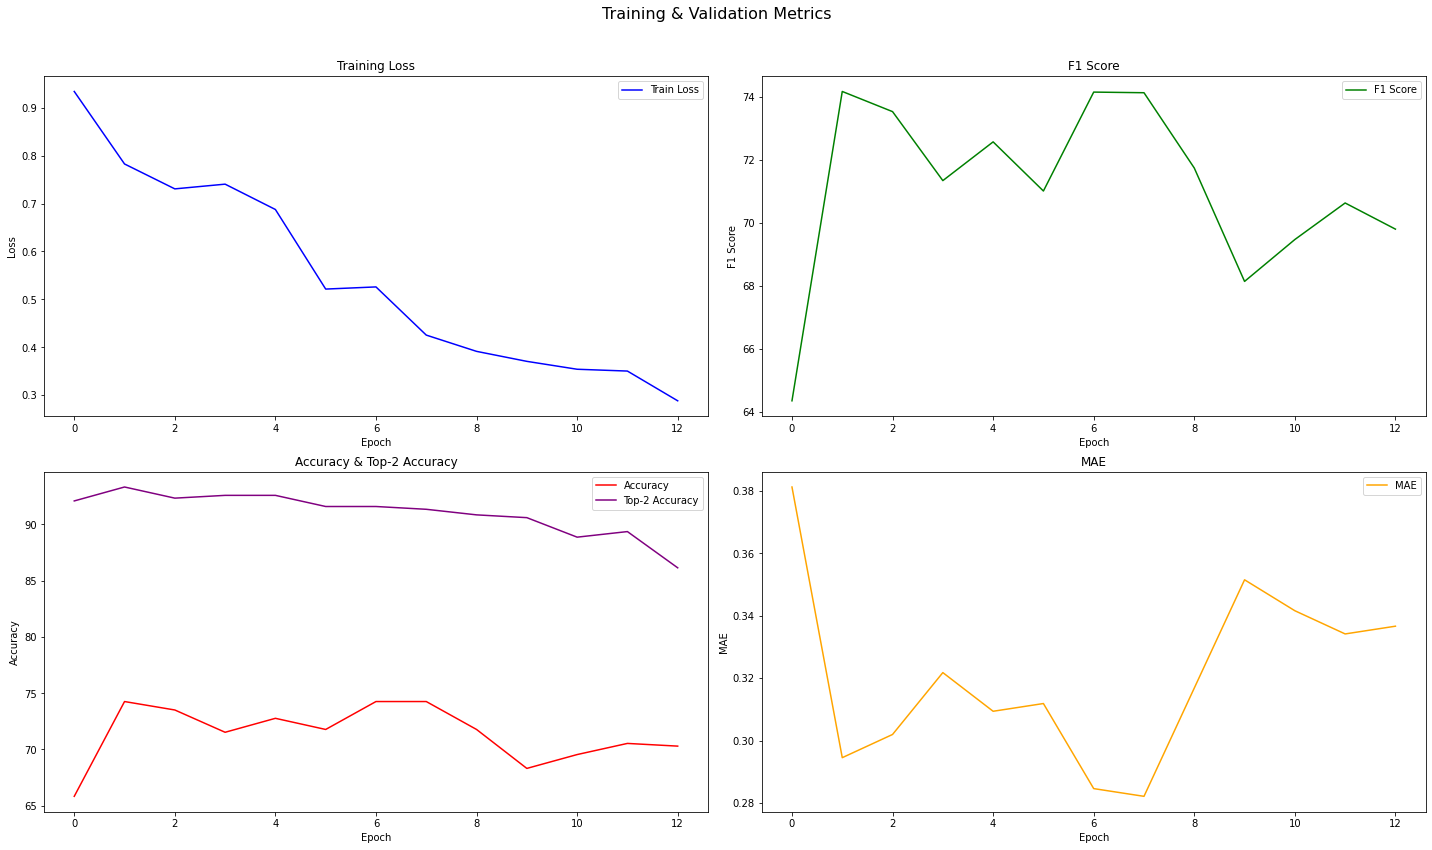

In [21]:
import matplotlib.pyplot as plt

# Setting up a larger canvas to display all graphs
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
fig.suptitle('Training & Validation Metrics', fontsize=16)

# Plotting the Training Loss
axes[0, 0].plot(train_losses, label="Train Loss", color='blue')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].set_title("Training Loss")
axes[0, 0].legend()

# If evaluations during training is enabled, plot the other metrics
if config.do_eval_during_train:
    # Plotting the F1 Score
    axes[0, 1].plot(val_f1, label="F1 Score", color='green')
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("F1 Score")
    axes[0, 1].set_title("F1 Score")
    axes[0, 1].legend()

    # Plotting Accuracy & Top-2 Accuracy on the same plot
    val_top2_acc_percentage = [v * 100 for v in val_top2_acc]
    axes[1, 0].plot(val_acc, label="Accuracy", color='red')
    axes[1, 0].plot(val_top2_acc_percentage, label="Top-2 Accuracy", color='purple')
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Accuracy")
    axes[1, 0].set_title("Accuracy & Top-2 Accuracy")
    axes[1, 0].legend()

    # Plotting the MAE
    axes[1, 1].plot(val_mae, label="MAE", color='orange')
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("MAE")
    axes[1, 1].set_title("MAE")
    axes[1, 1].legend()

# Display the plots
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust title spacing
plt.show()


## Inference

In [22]:
from transformers import AutoModel, AutoConfig, AutoTokenizer
import torch
import os

MODEL_PATH = output_dir # best model path

model = ClsModel()
loaded_state_dict = torch.load(os.path.join(MODEL_PATH, "model_weights.pth"))
model.load_state_dict(loaded_state_dict)
model.eval() 
tokenizer = model.tokenizer

def predict(text):
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {
        "input_ids": encoding["input_ids"],
        "attention_mask": encoding["attention_mask"],
        "token_type_ids": encoding["token_type_ids"]
    }
    with torch.no_grad():
        logit = model(inputs)

    prob = torch.nn.functional.softmax(logit, dim=-1)
    prediction = torch.argmax(prob, dim=-1)

    return prediction

In [23]:
text = "동남아는 똥남아가 아니라 갓남아임. 국결은 동남아인이랑 해도 성공임"

class_labels = ["hate", "dislike", "neutral", "like", "love"]

result = predict(text)
print(f'Preference: {class_labels[result.item()]}')

Preference: like
